# Project 6 - Time Series Analysis

# Objective

The main objective of the analysis is to forecast the tempurature based on its historic behaviour.

# Dataset

The data is referred from [Kaggle](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data) which includes climate data of Delhi, India.

Dataset includes following variables:

**date** - Date of format YYYY-MM-DD.

**meantemp** - Mean temperature averaged out from multiple 3 hour intervals in a day.

**humidity** - Humidity value for the day (units are grams of water vapor per cubic meter volume of air).

**wind_speed** - Wind speed measured in kmph.

**meanpressure** - Pressure reading of weather (measure in atm).

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import statsmodels.api as sm

In [2]:
data = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'], index_col='date')
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


# EDA

- Timeseries Decomposition (Trend, Seasonal, Noise).
- Data Smoothing.
- Conversion from non-stationary to stationary series.
- Plot Auto Correlation and Partial Auto Correlation.

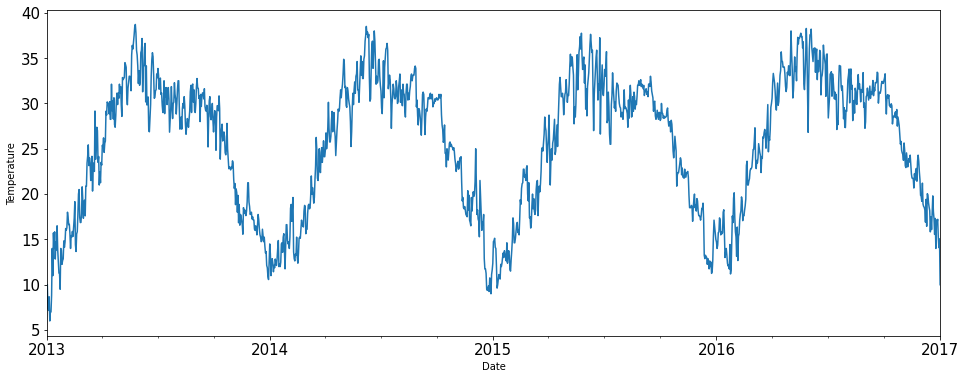

In [3]:
data["meantemp"].plot(figsize=(16, 6), fontsize=15)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

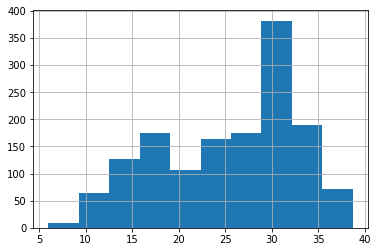

In [4]:
data["meantemp"].hist()
plt.show()

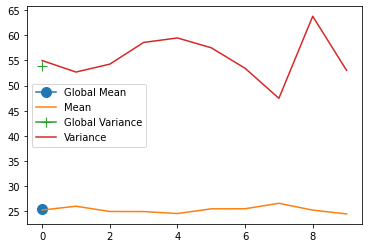

In [5]:
import random
import statistics

meanVal, varianceVal = [], []
for i in range(10):
    sample = random.sample(list(data.meantemp), 100)
    meanVal.append(np.mean(sample))
    varianceVal.append(statistics.variance(sample))

plt.plot(np.mean(data.meantemp), marker="o", markersize=10, label='Global Mean')
plt.plot(meanVal, label='Mean')
plt.plot(statistics.variance(data.meantemp), marker="+", markersize=10, label='Global Variance')
plt.plot(varianceVal, label='Variance')
plt.legend()
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

dfTest = adfuller(data.meantemp, autolag='AIC')

print('l. ADF: ' ,dfTest[0])
print('2. P-Value: ', dfTest[1])
print('3. Num Of Lags: ', dfTest[2])
print('4. Num Of Observations used For ADF Regression and Critical values Calculation: ', dfTest[3])
print('5. Critical Values:')
for key, val in dfTest[4].items():
    print('\t', key, ': ', val)

l. ADF:  -2.021069055920659
2. P-Value:  0.27741213723016633
3. Num Of Lags:  10
4. Num Of Observations used For ADF Regression and Critical values Calculation:  1451
5. Critical Values:
	 1% :  -3.4348647527922824
	 5% :  -2.863533960720434
	 10% :  -2.567831568508802


### Observations:
- By **Visual Inspection**, we can see a seansonality in the line graph and histogram.
- Considering a reasonable mean, variance and existence of correlation, the series is not a white noise.
- Histogram is not normally distributed thus indicates non-stationarity.
- Next being **Global and Local Checks**, we can again confirm difference in variance while constant mean, resulting in non-stationarity.
- Based on **Dickey-Fuller Test** (Hypothesis testing), the p-value is less than 0.05, thus non-stationary.

c:\users\mahim\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


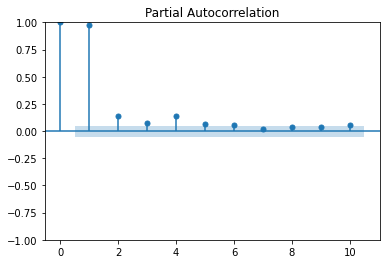

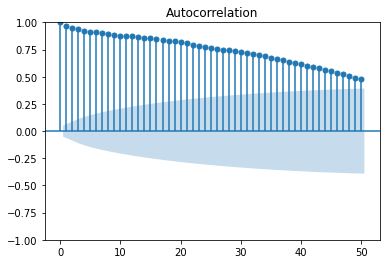

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(data.meantemp, lags=10)
acf = plot_acf(data.meantemp, lags=50)

### Observations:
- From **PACF**, there is correlation with lag of upto 4 above the error band.
- In **ACF**, due to direct and indirect effects taken into consideration, the lag 50 is also correlated to current series.

# Model Building

In [13]:
train = data.meantemp[:-30]
test = data.meantemp[-30:]
len(train)

1432

In [14]:
from statsmodels.tsa.ar_model import AutoReg
autoRegModel = AutoReg(train, lags=4).fit()
autoRegModel.summary()

c:\users\mahim\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1432
Model:                     AutoReg(4)   Log Likelihood               -2704.218
Method:               Conditional MLE   S.D. of innovations              1.608
Date:                Sun, 01 Jan 2023   AIC                           5420.437
Time:                        23:09:20   BIC                           5452.021
Sample:                    01-05-2013   HQIC                          5432.232
                         - 12-02-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5163      0.158      3.270      0.001       0.207       0.826
meantemp.L1     0.8069      0.026     30.849      0.000       0.756       0.858
meantemp.L2     0.0484      0.034      1.433      0.152      -0.018       0.115
meantemp.L3    -0.0263      0.034     -0.781      0.435      -0.092       0.040
meantemp.L4     0.1514      0.026      5.803      0.000       0.100       0.203
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0136           -0.0000j            1.0136           -0.0000
AR.2           -1.9511           -0.0000j            1.9511           -0.5000
AR.3            0.5557           -1.7408j            1.8273           -0.2008
AR.4            0.5557           +1.7408j            1.8273            0.2008
-----------------------------------------------------------------------------
"""

c:\users\mahim\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


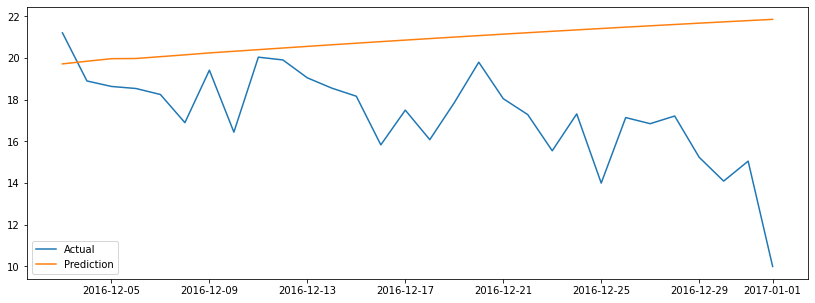

In [15]:
pred0 = autoRegModel.predict(start=len(train), end=len(data.meantemp)-1)
plt.figure(figsize=(14, 5))
plt.plot(test, label='Actual')
plt.plot(pred0, label='Prediction')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(test, pred0, squared=False)
rms

4.4577961380273665

**Totally opposite to the trend 😅**

**Let's try experimenting with other features of the data, might provide some value to the regression calculations.**

In [17]:
from statsmodels.tsa.ar_model import AutoReg
autoRegModel = AutoReg(train, lags=4, trend='n', seasonal=True, exog=data.drop(columns=['meantemp'])[:-30]).fit()
autoRegModel.summary()

c:\users\mahim\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1432
Model:             Seas. AutoReg-X(4)   Log Likelihood               -2616.159
Method:               Conditional MLE   S.D. of innovations              1.512
Date:                Sun, 01 Jan 2023   AIC                           5262.317
Time:                        23:09:26   BIC                           5341.278
Sample:                    01-05-2013   HQIC                          5291.805
                         - 12-02-2016                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
s(1,7)           4.3167      0.398     10.840      0.000       3.536       5.097
s(2,7)           4.4042      0.398     11.060      0.000       3.624       5.185
s(3,7)           4.2396      0.398     10.659      0.000       3.460       5.019
s(4,7)           4.2531      0.399     10.653      0.000       3.471       5.036
s(5,7)           4.2117      0.401     10.492      0.000       3.425       4.998
s(6,7)           4.1733      0.399     10.448      0.000       3.390       4.956
s(7,7)           4.3778      0.402     10.877      0.000       3.589       5.167
meantemp.L1      0.7385      0.025     29.306      0.000       0.689       0.788
meantemp.L2      0.0516      0.032      1.617      0.106      -0.011       0.114
meantemp.L3     -0.0118      0.032     -0.371      0.711      -0.074       0.051
meantemp.L4      0.1599      0.025      6.485      0.000       0.112       0.208
humidity        -0.0390      0.003    -13.394      0.000      -0.045      -0.033
wind_speed      -0.0189      0.010     -1.972      0.049      -0.038      -0.000
meanpressure    -0.0002      0.000     -0.862      0.389      -0.001       0.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0416           -0.0000j            1.0416           -0.0000
AR.2           -1.9128           -0.0000j            1.9128           -0.5000
AR.3            0.4726           -1.7073j            1.7715           -0.2070
AR.4            0.4726           +1.7073j            1.7715            0.2070
-----------------------------------------------------------------------------
"""

c:\users\mahim\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\users\mahim\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


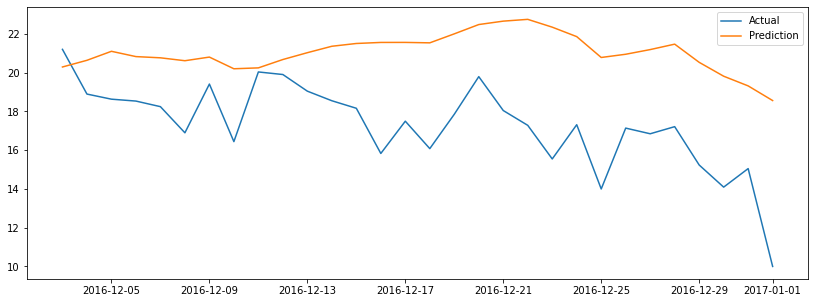

In [18]:
pred1 = autoRegModel.predict( start=len(train), end=len(data.meantemp)-1, exog_oos=data.drop(columns=['meantemp'])[-30:])
plt.figure(figsize=(14, 5))
plt.plot(test, label='Actual')
plt.plot(pred1, label='Prediction')
plt.legend()
plt.show()

In [19]:
rms = mean_squared_error(test, pred1, squared=False)
rms

4.271293281591886

**Following the trend with much ups and downs.**

In [20]:
import pmdarima
sarimaModel = pmdarima.arima.auto_arima(train, d=1, m=4, stationary=False, test='adf')

In [21]:
sarimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1432
Model:             SARIMAX(1, 1, 3)x(1, 0, [1], 4)   Log Likelihood               -2698.464
Date:                             Sun, 01 Jan 2023   AIC                           5410.929
Time:                                     23:12:32   BIC                           5447.792
Sample:                                 01-01-2013   HQIC                          5424.694
                                      - 12-02-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4085      0.125      3.268      0.001       0.163       0.654
ma.L1         -0.6266      0.125     -5.006      0.000      -0.872      -0.381
ma.L2         -0.0428      0.039     -1.106      0.269      -0.119       0.033
ma.L3         -0.0930      0.040     -2.304      0.021      -0.172      -0.014
ar.S.L4        0.9139      0.057     15.903      0.000       0.801       1.026
ma.S.L4       -0.8758      0.069    -12.654      0.000      -1.011      -0.740
sigma2         2.5428      0.072     35.078      0.000       2.401       2.685
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               296.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

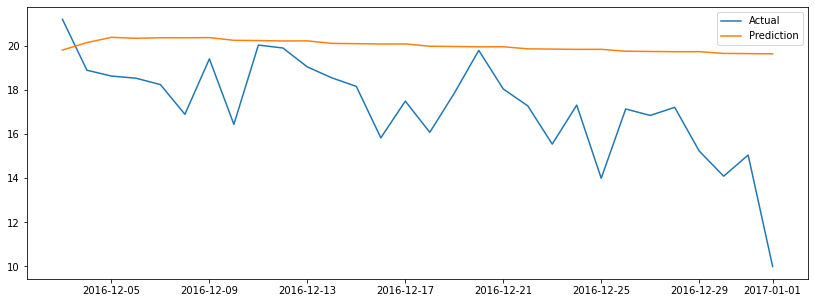

In [22]:
pred2 = sarimaModel.predict(n_periods=30)
plt.figure(figsize=(14, 5))
plt.plot(test, label='Actual')
plt.plot(pred2, label='Prediction')
plt.legend()
plt.show()

In [23]:
mean_squared_error(test, pred2, squared=False)

3.4199992717168044

**Line is following the trend straightly and RMSE is also lowered.**

In [24]:
trainAllVars = data[:-30]
testAllVars = data[-30:]

In [25]:
sarimaModelOnAllVars = pmdarima.arima.auto_arima(trainAllVars.meantemp, 
                                                 X=trainAllVars.drop(columns=['meantemp']), 
                                                 d=2, m=4, stationary=False, test='adf', trace=True)

sarimaModelOnAllVars.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=4809.368, Time=7.00 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=5695.930, Time=2.66 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=5407.564, Time=1.75 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=4.16 sec
 ARIMA(2,2,2)(0,0,1)[4]             : AIC=4748.048, Time=6.54 sec
 ARIMA(2,2,2)(0,0,0)[4]             : AIC=4883.747, Time=4.00 sec
 ARIMA(2,2,2)(0,0,2)[4]             : AIC=4829.505, Time=9.56 sec
 ARIMA(2,2,2)(1,0,0)[4]             : AIC=4895.253, Time=5.54 sec
 ARIMA(2,2,2)(1,0,2)[4]             : AIC=4901.521, Time=11.48 sec
 ARIMA(1,2,2)(0,0,1)[4]             : AIC=inf, Time=6.33 sec
 ARIMA(2,2,1)(0,0,1)[4]             : AIC=4932.072, Time=5.30 sec
 ARIMA(3,2,2)(0,0,1)[4]             : AIC=4641.521, Time=8.00 sec
 ARIMA(3,2,2)(0,0,0)[4]             : AIC=inf, Time=5.87 sec
 ARIMA(3,2,2)(1,0,1)[4]             : AIC=4656.687, Time=8.03 sec
 ARIMA(3,2,2)(0,0,2)[4]             : AIC=4656.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1432
Model:             SARIMAX(3, 2, 2)x(1, 0, 2, 4)   Log Likelihood               -2308.139
Date:                           Sun, 01 Jan 2023   AIC                           4640.278
Time:                                   23:15:47   BIC                           4703.464
Sample:                               01-01-2013   HQIC                          4663.873
                                    - 12-02-2016                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
humidity        -0.1402      0.003    -43.014      0.000      -0.147      -0.134
wind_speed      -0.0286      0.006     -4.758      0.000      -0.040      -0.017
meanpressure -3.924e-05      0.000     -0.128      0.898      -0.001       0.001
ar.L1           -0.7070      0.056    -12.600      0.000      -0.817      -0.597
ar.L2           -0.2886      0.034     -8.463      0.000      -0.355      -0.222
ar.L3           -0.3550      0.034    -10.484      0.000      -0.421      -0.289
ma.L1           -0.3403      0.057     -6.004      0.000      -0.451      -0.229
ma.L2           -0.6049      0.054    -11.295      0.000      -0.710      -0.500
ar.S.L4         -0.2485      0.334     -0.744      0.457      -0.903       0.406
ma.S.L4         -0.0253      0.339     -0.075      0.941      -0.690       0.640
ma.S.L8         -0.1326      0.094     -1.410      0.159      -0.317       0.052
sigma2           1.4043      0.036     39.427      0.000       1.334       1.474
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               688.40
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.22
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

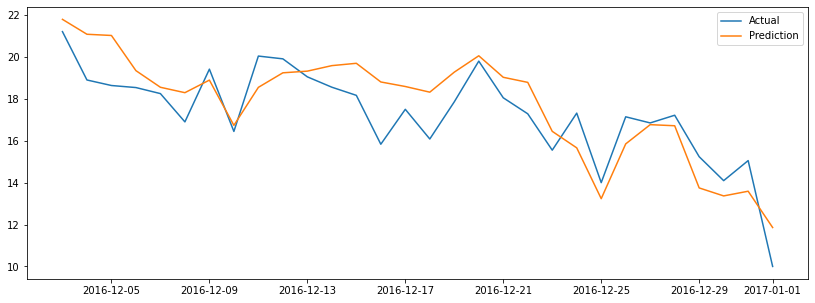

In [26]:
pred3 = sarimaModelOnAllVars.predict(n_periods=30, X=testAllVars.drop(columns=['meantemp']))
plt.figure(figsize=(14, 5))
plt.plot(test, label='Actual')
plt.plot(pred3, label='Prediction')
plt.legend()
plt.show()

In [27]:
mean_squared_error(test, pred3, squared=False)

1.3504414642350195

**Ahh!! Looks quite similar to the actual values.**

# Best Model to Choose

| Models                              | Root Mean Square Error |
|-------------------------------------|------------------------|
| Auto Regressive Model               | 4.4578                 |
| AR Model with supporting features   | 4.2713                 |
| SARIMA Model                        | 3.4199                 |
| **SARIMA with supporting features** | **1.3504**             |

Based on the Root Mean square error of each of the models created, **SARIMA** outperformed other models with RMSE of 1.3504.

# Future Scope
Will try to use some deep learning models to reduce the errors and provide more accurate results. Also can add multiple datasets to build robust model.